# Image Segmentation for Coin Classification

## 0. Import libraries

In [1]:
import skimage as ski  # Image handling library
import numpy as np  # Basic array handling
import matplotlib.pyplot as plt  # Plotting results
import os  # Dealing with paths and loading images
import cv2 as cv

from typing import Callable

## 1. Load in images
This is only for loading in training data as given in the correct format of the Kaggle challenge.

In [151]:
path_to_train = "data/train/"
train_folders = sorted(os.listdir(path_to_train))

# Load in all images from the training set into this dictionary
train_images_grouped = {}

for folder in train_folders:
    train_images = []
    folder_path = os.path.join(path_to_train, folder)
    if not os.path.isdir(folder_path):
        continue
    images = os.listdir(folder_path)
    for image in images:
        image_path = os.path.join(folder_path, image)
        loaded_image = cv.imread(image_path)
        loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB) 
        train_images.append(loaded_image)
    folder = folder.replace(" ", "")  # Remove whitespace
    import re
    folder = re.sub("[0-9.]", "", folder) # Remove numbers and '.'
    train_images_grouped[str(folder)] = train_images



In [3]:
image_num = 0
# Load in the first image of each class as a sample, test image
neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
hand_bg_sample = train_images_grouped["hand"][image_num]
neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]


### 1.1 Sanity check
Here we check if the number of training images loaded for each class is correct.

In [4]:
N = 0 
for group in train_images_grouped:
    group_len = len(train_images_grouped[group])
    N += group_len
    print(f"Group name: '{group}' \n with length: {group_len} \n")

print(f"N: {N}")

Group name: 'neutral_bg' 
 with length: 16 

Group name: 'noisy_bg' 
 with length: 15 

Group name: 'hand' 
 with length: 10 

Group name: 'neutral_bg_outliers' 
 with length: 17 

Group name: 'noisy_bg_outliers' 
 with length: 16 

Group name: 'hand_outliers' 
 with length: 7 

N: 81


In [5]:
def gimp2opencvHSV(h, s, v):
    """
    Convert GIMP HSV values to OpenCV HSV values.
    GIMP uses the range [0, 360] for H, [0, 100] for S and V.
    OpenCV uses the range [0, 180] for H, [0, 255] for S and V.
    """
    return 180 * (h / 360), 255 * (s / 100), 255 * (v / 100)

In [178]:
# Pre-processing filters to separate coins from neutral, noisy and hand backgrounds
def get_contours(img_original):
    import skimage.exposure
    
    img = img_original.copy()

    # The following conversions are from GIMP to OpenCV
    # GIMP uses (360, 100, 100), OpenCV uses (180, 255, 255)
    h_upper = 180 * (65 / 360)
    h_lower = 180 * (18 / 360)

    s_upper = 255 * (85 / 100)
    s_lower = 255 * (10 / 100)

    v_upper = 255 * (95 / 100)
    v_lower = 255 * (40 / 100)

    # Use the above range to create another HSV image
    img = cv.cvtColor(img, cv.COLOR_RGB2HSV)

    # Main thresholding for background separation
    img_thres = cv.inRange(
        img, (h_lower, s_lower, v_lower), (h_upper, s_upper, v_upper)
    )

    # Additional mask for dimly lit background 
    background_mask = cv.inRange(img, (180 * 32/360, 255 * 12/100, 255 * 72/100), (180 * 38/360, 255 * 28/100, 255 * 78/100))

    # Additional mask for light silver coins
    light_silver_coin_mask = cv.inRange(img, gimp2opencvHSV(190, 6.2, 72.3), gimp2opencvHSV(205, 10.3, 81.2))


    img[img_thres == 0 & ~(light_silver_coin_mask == 255)] = 0
    img[background_mask == 255] = 0

    img = cv.cvtColor(img, cv.COLOR_HSV2RGB)

    # Convert to grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # # Gaussian blur
    # img_blur = cv.GaussianBlur(img_gray, (21, 21), 0)

    ret, thresh = cv.threshold(
        img_gray, 0, 255, cv.THRESH_BINARY_INV
    )

    

    # Closing small holes
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=2)

    kernel = np.ones((10, 10), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=3)

    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=3)

    # return thresh, []

    sure_bg = cv.dilate(thresh, kernel, iterations=8)

    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)

    # return dist_transform

    ret, sure_fg = cv.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

    # return sure_fg

    # kernel = np.ones((16, 16), np.uint8)
    # sure_fg = cv.erode(sure_fg, kernel, iterations=8)
    # kernel = np.ones((10, 10), np.uint8)
    # sure_fg = cv.dilate(sure_fg, kernel, iterations=4)

    # return sure_fg

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    # Connected Components determines the connectivity of blob-like regions in a binary image.
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Optionally mark -1 boundaries if needed

    # Create an output image to draw on
    output_img = img_original.copy()

    all_contours = []
    # Process each region
    for label in np.unique(markers):
        if label == 0 or label == 1:  # Background or borders
            continue

        # Create a mask for the current region
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask[markers == label] = 255

        # Find contours and get the bounding box
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        # print(f"Length of contours: {len(contours)}")
        for cntr in contours:
            area = cv.contourArea(cntr)

            # Check if contour is big enough
            if area < 70000 or area > 700000:
                continue

            # # Check if contour is "cirular" enough
            # perimeter = cv.arcLength(cntr, True)

            # # Calculate circularity
            # if perimeter == 0:
            #     continue  # Avoid division by zero

            # circularity = 4 * np.pi * (area / (perimeter**2))

            # if circularity < 0.5:
            #     continue

            # # Calculate convexity
            # hull = cv.convexHull(cntr)
            # hull_area = cv.contourArea(hull)

            # if hull_area == 0:
            #     continue
            # convexity = area / hull_area

            # if convexity < 0.5:
            #     continue

            # Calculate bounding box
            x, y, w, h = cv.boundingRect(cntr)
            # Draw bounding box
            cv.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 15)

            # Draw contour (optional)
            # cv.drawContours(output_img, [cntr], -1, (0, 0, 255), 2)
            all_contours.append(cntr)

    return output_img, all_contours

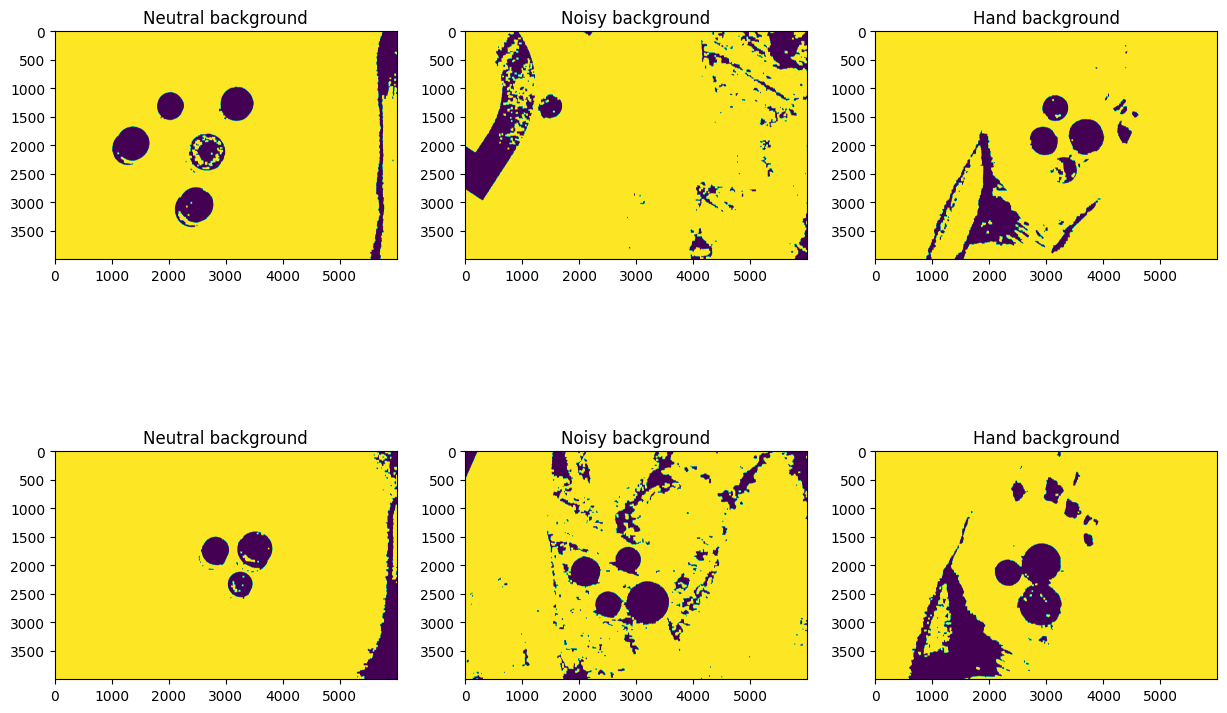

In [179]:
TOTAL_IMAGES = 1
for image_num in range(TOTAL_IMAGES):
    neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
    noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
    hand_bg_sample = train_images_grouped["hand"][image_num]
    neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
    noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
    hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(get_contours(neutral_bg_sample)[0])
    plt.title("Neutral background")
    plt.subplot(2, 3, 2)
    plt.imshow(get_contours(noisy_bg_sample)[0])
    plt.title("Noisy background")
    plt.subplot(2, 3, 3)
    plt.imshow(get_contours(hand_bg_sample)[0])
    plt.title("Hand background")
    plt.subplot(2, 3, 4)
    plt.imshow(get_contours(neutral_bg_sample_ood)[0])
    plt.title("Neutral background")
    plt.subplot(2, 3, 5)
    plt.imshow(get_contours(noisy_bg_sample_ood)[0])
    plt.title("Noisy background")
    plt.subplot(2, 3, 6)
    plt.imshow(get_contours(hand_bg_sample_ood)[0])
    plt.title("Hand background")
    plt.show()


In [149]:
# Crop the bounding boxes from the images
def crop_bounding_boxes(img_original, contours):
    '''
    Takes in an image with multiple coins and its contours that represent the coins.
    Outputs a list of cropped images.
    '''

    img = img_original.copy()
    cropped_images = []

    for cntr in contours:
        area = cv.contourArea(cntr)

        # Check if contour is big enough
        if area < 70000 or area > 700000:
            continue

        x, y, w, h = cv.boundingRect(cntr)
        cropped_images.append(img[y:y+h, x:x+w])

    return cropped_images

In [156]:
path_to_test = "data/test/"

for test_image in os.listdir(path_to_test):
    test_image_path = os.path.join(path_to_test, test_image)
    loaded_image = cv.imread(test_image_path)
    loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB) 
    filtered_image, contours = get_contours(loaded_image)
    cropped_coins = crop_bounding_boxes(loaded_image, contours)
    cropped_coins_folder_path = f"output/{test_image}"
    cropped_coins_folder_path = cropped_coins_folder_path.replace(".JPG", "")
    os.mkdir(cropped_coins_folder_path)
    for i, coin in enumerate(cropped_coins):
        path_to_save = os.path.join(cropped_coins_folder_path, f"coin_{i}.jpg")
        cv.imwrite(path_to_save, cv.cvtColor(coin, cv.COLOR_RGB2BGR))

KeyboardInterrupt: 

In [10]:
# def get_contours_hough(img_original):
#     import skimage.exposure
#     import skimage.morphology as morph

#     img = img_original.copy()
#     hh, ww = img.shape[:2]

#     # Resize image to 1/4
#     # img = cv.resize(img, dsize=(0,0), fx=0.25, fy=0.25)
#     # The following conversions are from GIMP to OpenCV
#     # GIMP uses (360, 100, 100), OpenCV uses (180, 255, 255)
#     h_upper = 180 * (65 / 360)
#     h_lower = 180 * (18 / 360)

#     s_upper = 255 * (85 / 100)
#     s_lower = 255 * (10 / 100)

#     v_upper = 255 * (95 / 100)
#     v_lower = 255 * (40 / 100)

#     # Use the above range to create another HSV image
#     img = cv.cvtColor(img, cv.COLOR_RGB2HSV)

#     # Main thresholding for background separation
#     img_thres = cv.inRange(
#         img, (h_lower, s_lower, v_lower), (h_upper, s_upper, v_upper)
#     )

#     # Additional mask for dimly lit background 
#     background_mask = cv.inRange(img, (180 * 32/360, 255 * 12/100, 255 * 72/100), (180 * 38/360, 255 * 28/100, 255 * 78/100))

#     # Additional mask for light silver coins
#     light_silver_coin_mask = cv.inRange(img, gimp2opencvHSV(190, 6.2, 72.3), gimp2opencvHSV(205, 10.3, 81.2))


#     img[img_thres == 0 & ~(light_silver_coin_mask == 255)] = 0
#     img[background_mask == 255] = 0

#     img = cv.cvtColor(img, cv.COLOR_HSV2RGB)

#     # Convert to grayscale
#     gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

#     # Gaussian filter
#     gray = cv.GaussianBlur(gray, ksize=(21, 21), sigmaX=0, sigmaY=0)

#     # Increase contrast
#     contrast = (
#         skimage.exposure.rescale_intensity(
#             gray, in_range=(100, 200), out_range=(0, 255)
#         )
#         .clip(0, 255)
#         .astype(np.uint8)
#     )

#     # Threshold
#     _, contrast = cv.threshold(contrast, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

#     # Invert
#     contrast = cv.bitwise_not(contrast)

#     # Morphological operations

#     # Hand bg
#     # kernel = np.ones((12, 12), np.uint8)
#     # contrast = cv.morphologyEx(contrast, cv.MORPH_CLOSE, kernel, iterations=5)

#     # contrast = cv.morphologyEx(contrast, cv.MORPH_OPEN, kernel, iterations=3)

#     # Neutral bg
#     # kernel = np.ones((10, 10), np.uint8)
#     # contrast = cv.morphologyEx(contrast, cv.MORPH_CLOSE, kernel, iterations=5)

#     # Find contours
#     contours, _ = cv.findContours(contrast, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#     # Draw contours
#     result = img.copy()
#     cv.drawContours(result, contours, -1, (0, 255, 0), 3)

#     # Draw bounding boxes
#     for cntr in contours:
#         area = cv.contourArea(cntr)

#         # Check if contour is big enough
#         if area < 70000 or area > 700000:
#             continue

#         # # Check if contour is "cirular" enough
#         # perimeter = cv.arcLength(cntr, True)

#         # # Calculate circularity
#         # if perimeter == 0:
#         #     continue

#         # circularity = 4 * np.pi * (area / (perimeter**2))

#         # if circularity < 0.2:
#         #     continue

#         x, y, w, h = cv.boundingRect(cntr)
#         cv.rectangle(result, (x, y), (x + w, y + h), (255, 0, 0), 15)

#     # save results
#     cv.imwrite("coin_contrast5.jpg", contrast)
#     cv.imwrite("coin_circle5.jpg", result)

#     # ----------------------------
#     # # Convert img to HSV
#     # img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

#     # img_hsv = cv.GaussianBlur(img_hsv, (5, 5), 0)

#     # # Define the color ranges for the the different coins, based on analysis of reference images
#     # coin_color_ranges = {
#     #     # TODO: Define the color ranges for the different coins
#     #     "chf_silver": (gimp2opencvHSV(30, 25, 60), gimp2opencvHSV(40, 35, 75)),
#     #     "chf_gold": (gimp2opencvHSV(35, 45, 60), gimp2opencvHSV(45, 55, 70)),
#     #     "eur_gold_segment": (
#     #         gimp2opencvHSV(35, 40, 70),
#     #         gimp2opencvHSV(45, 50, 80),
#     #     ),
#     #     "eur_silver_segment": (
#     #         gimp2opencvHSV(30, 25, 60),
#     #         gimp2opencvHSV(40, 40, 70),
#     #     ),
#     #     "eur_gold": (gimp2opencvHSV(35, 55, 70), gimp2opencvHSV(45, 65, 80)),
#     #     "eur_gold_shiny": (gimp2opencvHSV(30, 65, 30), gimp2opencvHSV(50, 75, 50)),
#     #     "eur_bronze": (gimp2opencvHSV(15, 55, 75), gimp2opencvHSV(25, 65, 85)),
#     # }

#     # coin_masks = {}

#     # for coin, (lower, upper) in coin_color_ranges.items():
#     #     lower = np.array(lower)
#     #     upper = np.array(upper)
#     #     coin_masks[coin] = cv.inRange(img_hsv, lower, upper)

#     # detected_coins = {}

#     # for coin, mask in coin_masks.items():
#     #     print(f"Processing coin: {coin}")
#     #     kernel = np.ones((5, 5), np.uint8)
#     #     mask = cv.dilate(mask, kernel, iterations=2)
#     #     mask = cv.erode(mask, kernel, iterations=1)

#     #     # Use the mask to detect circles
#     #     circles = cv.HoughCircles(
#     #         mask,
#     #         cv.HOUGH_GRADIENT,
#     #         dp=1.2,
#     #         minDist=50,
#     #         param1=50,
#     #         param2=30,
#     #         minRadius=50,
#     #         maxRadius=400,
#     #     )

#     #     if circles is not None:
#     #         circles = np.round(circles[0, :]).astype("int")
#     #         detected_coins[coin] = circles

#     #         # Draw circles on the original image
#     #         for x, y, r in circles:
#     #             cv.circle(img, (x, y), r, (0, 255, 0), 2)
#     #             cv.putText(
#     #                 img,
#     #                 coin,
#     #                 (x - r, y - r - 10),
#     #                 cv.FONT_HERSHEY_SIMPLEX,
#     #                 0.6,
#     #                 (255, 0, 0),
#     #                 2,
#     #             )

#     # # show each mask
#     # fig, axs = plt.subplots(1, len(coin_masks) + 1, figsize=(20, 10))
#     # axs[0].imshow(img)
#     # axs[0].set_title("Original Image")
#     # for i, (coin, mask) in enumerate(coin_masks.items()):
#     #     axs[i + 1].imshow(mask, cmap="gray")
#     #     axs[i + 1].set_title(coin)

#     # plt.show()

#     # # rows = img.shape[0]
#     # # print("Getting hough circles...")
#     # # circles = cv.HoughCircles(
#     # #     img,
#     # #     cv.HOUGH_GRADIENT,
#     # #     minDist=50,
#     # #     dp=1.1,
#     # #     param1=150,
#     # #     param2=50,
#     # #     minRadius=0,
#     # #     maxRadius=0,
#     # # )
#     # # print("Got hough circles.")

#     # # if circles is not None:
#     # #     circles = np.uint16(np.around(circles))
#     # #     for i in circles[0, :]:
#     # #         center = (i[0], i[1])
#     # #         # circle center
#     # #         cv.circle(img, center, 5, (0, 100, 100), 3)

#     # #         # circle outline
#     # #         radius = i[2]
#     # #         cv.circle(img, center, radius, (255, 0, 255), 5)
#     # #         cv.rectangle(img, center - radius, center + radius, (255, 0, 0), 5)

#     # # plt.imshow(img)
#     # # return circles


# print("Getting contours...")

# plt.imshow(neutral_bg_sample_ood)

# # circles = get_contours_hough(neutral_bg_sample_ood)
# # print("Retrieved contours.")


# # Crop the bounding boxes from the images
# # def crop_bounding_boxes_hough(img_original, circles):
# #     """
# #     Takes in an image with multiple coins and its contours that represent the coins.
# #     Outputs a list of cropped images.
# #     """

# #     img = img_original.copy()
# #     cropped_images = []

# #     if circles is not None:
# #         circles = np.uint16(np.around(circles))
# #         for circle in circles[0, :]:
# #             center = (circle[0], circle[1])
# #             radius = circle[2]
# #             x, y = center - radius
# #             l = radius * 2
# #             cropped_images.append(img[y : y + l, x : x + l])

# #     return cropped_images


# # cropped_coins = crop_bounding_boxes_hough(neutral_bg_sample, circles)
# # for i, coin in enumerate(cropped_coins):
# #     cv.imwrite(f"coin_{i}.jpg")

# # path_to_test = "data/test/"

# # for test_image in os.listdir(path_to_test):
# #     test_image_path = os.path.join(path_to_test, test_image)
# #     loaded_image = cv.imread(test_image_path, cv.IMREAD_COLOR)
# #     print(f"Getting contours for image: {test_image}")
# #     circles = get_contours_hough(loaded_image)
# #     print("Retrieved contours. Cropping coins...")
# #     cropped_coins = crop_bounding_boxes_hough(loaded_image, circles)
# #     print("Cropped coins.")
# #     cropped_coins_folder_path = f"output/{test_image}"
# #     cropped_coins_folder_path = cropped_coins_folder_path.replace(".JPG", "")
# #     os.mkdir(cropped_coins_folder_path)
# #     for i, coin in enumerate(cropped_coins):
# #         path_to_save = os.path.join(cropped_coins_folder_path, f"coin_{i}.jpg")
# #         cv.imwrite(path_to_save, cv.cvtColor(coin, cv.COLOR_RGB2BGR))

In [11]:
# def get_contours_new(img_original):
#     img = img_original.copy()

#     import numpy as np
#     from skimage.io import imread
#     from skimage.color import rgb2gray
#     from skimage.filters import threshold_otsu, sobel
#     from skimage.segmentation import watershed
#     from scipy.ndimage import binary_fill_holes
#     from skimage.morphology import area_opening


#     # Resize
#     img = cv.resize(img, dsize=(0,0), fx=0.25, fy=0.25)


#     img = rgb2gray(img) * 255   

#     # Blur
#     img = cv.GaussianBlur(img, (3, 3), 0)

#     # Sobel
#     elevation_map = sobel(img)
#     t = threshold_otsu(img)

#     markers = np.zeros_like(img)
#     markers[img < t] = 1
#     markers[img > t] = 2

#     # change markers dtype to int
#     markers = markers.astype(int)

#     segmented = watershed(elevation_map, markers)
#     segmented = binary_fill_holes(segmented - 1)

#     segmented = area_opening(segmented, area_threshold=10, connectivity=1)  


#     # save results
#     plt.imshow(segmented)



# print("Getting contours...")
# circles = get_contours_new(neutral_bg_sample)
# print("Retrieved contours.")

In [12]:
# # Background substraction

# # Distribution of neutral background
# # ---
# # Get the background model
# neutral_bg_images = train_images_grouped["neutral_bg"]
# neutral_bg_images_ood = train_images_grouped["neutral_bg_outliers"]
# print(f"Number of images in neutral background: {len(neutral_bg_images)}")
# print(f"Number of images in neutral background ood: {len(neutral_bg_images_ood)}")

# # Get pixel-wise average of the images
# neutral_bg_images = np.array(neutral_bg_images)
# neutral_bg_images_ood = np.array(neutral_bg_images_ood)

# neutral_bg_avg = np.mean(neutral_bg_images, axis=0, dtype=np.int32)
# neutral_bg_avg_ood = np.mean(neutral_bg_images_ood, axis=0, dtype=np.int32)

# # Take average between non-ood and ood
# neutral_bg_avg = (neutral_bg_avg + neutral_bg_avg_ood) // 2
# # ---

# # Distribution of noisy background type A
# # ---
# # Get the background model
# noisy_bg_images = train_images_grouped["noisy_bg"]
# print(f"Number of images in noisy background: {len(noisy_bg_images)}")

# # Get pixel-wise average of the images
# noisy_bg_images = np.array(noisy_bg_images)
# noisy_bg_avg = np.mean(noisy_bg_images, axis=0, dtype=np.int32)
# # ---

# # Distribution of noisy background type B
# # ---
# # Get the background model
# noisy_bg_images_ood = train_images_grouped["noisy_bg_outliers"]
# print(f"Number of images in noisy background ood: {len(noisy_bg_images_ood)}")

# # Get pixel-wise average of the images
# noisy_bg_images_ood = np.array(noisy_bg_images_ood)
# noisy_bg_avg_ood = np.mean(noisy_bg_images_ood, axis=0, dtype=np.int32)
# # ---

# # Distribution of hand background
# # TODO

In [14]:
# # Create a figure to hold the subplots
# plt.figure(figsize=(15, 5))  # Adjust the size as needed

# # Plot the neutral background average
# plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
# plt.imshow(neutral_bg_avg, cmap='gray')
# plt.title('Average Neutral Background')
# plt.axis('off')  # Hide the axes

# # Plot the noisy background average
# plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
# plt.imshow(noisy_bg_avg, cmap='gray')
# plt.title('Average Noisy Background Type A')
# plt.axis('off')  # Hide the axes

# # Plot the noisy background outlier average
# plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
# plt.imshow(noisy_bg_avg_ood, cmap='gray')
# plt.title('Average Noisy Background Type B')
# plt.axis('off')  # Hide the axes

# # Display the plot
# plt.tight_layout()  # Adjust layout to not overlap
# plt.show()

In [15]:
# import skimage.exposure

# # Background substraction
# def subtract_background(image, background):
#     """
#     Subtract the background from the image.
#     Image and background should be in the same format.
#     They should be np.float32 and in the range [0, 1].
#     """
#     return cv.absdiff(image, background)

# # Pre-process the images
# def preprocess_image(image, background):
#     """
#     Pre-process the image by subtracting the background.
#     """
#     # Convert the image to a numpy array and in the proper format
#     img = image.copy()
#     img = np.array(img)
#     img = img.astype(np.int32)


#     # Perform background subtraction
#     background = background.astype(np.uint8)
#     background = cv.GaussianBlur(background, (13, 13), 0)
#     background = background.astype(np.int32)

#     foreground = subtract_background(img, background)
#     foreground = foreground.astype(np.uint8)

#     # Convert to grayscale
#     gray_foreground = cv.cvtColor(foreground, cv.COLOR_RGB2GRAY)

#     # Median filter
#     gray_foreground = cv.medianBlur(gray_foreground, 3)



#     return gray_foreground


# plt.imshow(preprocess_image(neutral_bg_sample, neutral_bg_avg), cmap='gray')


NameError: name 'neutral_bg_avg' is not defined

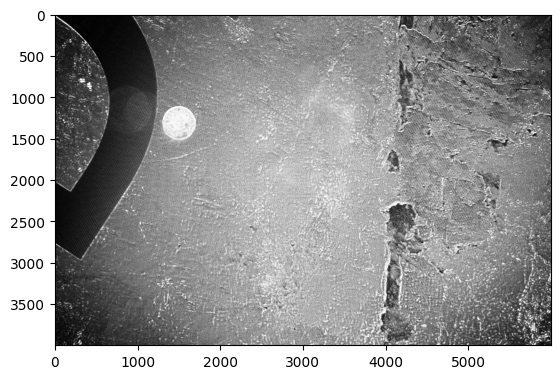

In [ ]:
# plt.imshow(preprocess_image(noisy_bg_sample, noisy_bg_avg),cmap='gray')

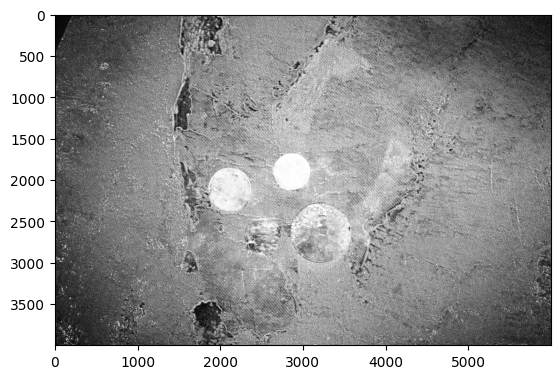

In [ ]:
# plt.imshow(preprocess_image(noisy_bg_sample_ood, noisy_bg_avg_ood), cmap='gray')

### Getting the background models

In [16]:
# Distribution of neutral background
# ---
# Get the background model
neutral_bg_images = train_images_grouped["neutral_bg"]
neutral_bg_images_ood = train_images_grouped["neutral_bg_outliers"]
print(f"Number of images in neutral background: {len(neutral_bg_images)}")
print(f"Number of images in neutral background ood: {len(neutral_bg_images_ood)}")

# Get pixel-wise average of the images
neutral_bg_images = np.array(neutral_bg_images)
neutral_bg_images_ood = np.array(neutral_bg_images_ood)

neutral_bg_avg = np.mean(neutral_bg_images, axis=0, dtype=np.int32)
neutral_bg_avg_ood = np.mean(neutral_bg_images_ood, axis=0, dtype=np.int32)

# Take average between non-ood and ood
neutral_bg_avg = (neutral_bg_avg + neutral_bg_avg_ood) // 2
# ---

# Distribution of noisy background type A
# ---
# Get the background model
noisy_bg_images = train_images_grouped["noisy_bg"]
print(f"Number of images in noisy background: {len(noisy_bg_images)}")

# Get pixel-wise average of the images
noisy_bg_images = np.array(noisy_bg_images)
noisy_bg_avg = np.mean(noisy_bg_images, axis=0, dtype=np.int32)
# ---

# Distribution of noisy background type B
# ---
# Get the background model
noisy_bg_images_ood = train_images_grouped["noisy_bg_outliers"]
print(f"Number of images in noisy background ood: {len(noisy_bg_images_ood)}")

# Get pixel-wise average of the images
noisy_bg_images_ood = np.array(noisy_bg_images_ood)
noisy_bg_avg_ood = np.mean(noisy_bg_images_ood, axis=0, dtype=np.int32)
# ---

# Distribution of hand background
# ---
# Get the background model
hand_bg_images = train_images_grouped["hand"]
hand_bg_images_ood = train_images_grouped["hand_outliers"]
print(f"Number of images in hand background: {len(hand_bg_images)}")
print(f"Number of images in hand background ood: {len(hand_bg_images_ood)}")

# Get pixel-wise average of the images
hand_bg_images = np.array(hand_bg_images)
hand_bg_avg = np.mean(hand_bg_images, axis=0, dtype=np.int32)

hand_bg_images_ood = np.array(hand_bg_images_ood)
hand_bg_avg_ood = np.mean(hand_bg_images_ood, axis=0, dtype=np.int32)

# Take average between non-ood and ood
hand_bg_avg = (hand_bg_avg + hand_bg_avg_ood) // 2
# ---

Number of images in neutral background: 16
Number of images in neutral background ood: 17
Number of images in noisy background: 15
Number of images in noisy background ood: 16
Number of images in hand background: 10
Number of images in hand background ood: 7


In [144]:
import cv2
import numpy as np
from skimage import filters, measure, morphology
import matplotlib.pyplot as plt


def show_image(image, title="Image", cmap_type="gray"):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis("off")
    plt.show()


def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        limg = cv2.merge([cl, a, b])
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    else:  # Grayscale image
        enhanced_img = clahe.apply(image)
    return enhanced_img


# Apply thresholding
def apply_threshold(image, method="otsu"):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    thresh_val = (
        filters.threshold_otsu(gray) if method == "otsu" else filters.threshold_li(gray)
    )
    binary = gray > thresh_val
    return binary


def clean_image(binary_image):
    # Removing small holes
    cleaned = morphology.remove_small_holes(binary_image, area_threshold=500)

    # Erode without going back to the original size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    cleaned = cv2.erode(cleaned.astype(np.uint8), kernel, iterations=3)

    return cleaned


def detect_coins(binary_image, original_image):
    all_contours = []
    output_img = original_image.copy()
    contours, _ = cv2.findContours(
        binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    for contour in contours:
        if (
            cv2.contourArea(contour) > 70000 and cv2.contourArea(contour) < 700000
        ):  # Adjust size threshold based on your need
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 10)
            all_contours.append(contour)

    return output_img, all_contours

def watershed(binary_image, original_image):
    img = original_image.copy()
    
    kernel = np.ones((13, 13), np.uint8)
    sure_bg = cv.dilate(binary_image, kernel, iterations=5)

    # return sure_bg, []

    dist_transform = cv.distanceTransform(binary_image, cv.DIST_L1, 5)

    ret, sure_fg = cv.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # return sure_fg, []
    # return unknown, []

    # Marker labelling
    # Connected Components determines the connectivity of blob-like regions in a binary image.
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Optionally mark -1 boundaries if needed

    # Create an output image to draw on
    output_img = img.copy()

    all_contours = []
    # Process each region
    for label in np.unique(markers):
        if label == 0 or label == 1:  # Background or borders
            continue

        # Create a mask for the current region
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask[markers == label] = 255

        # Find contours and get the bounding box
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        # print(f"Length of contours: {len(contours)}")
        for cntr in contours:
            area = cv.contourArea(cntr)

            # Check if contour is big enough
            if area < 70000 or area > 700000:
                continue

            # Calculate bounding box
            x, y, w, h = cv.boundingRect(cntr)
            # Draw bounding box
            cv.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 15)

            all_contours.append(cntr)

    return output_img, all_contours


from skimage.metrics import structural_similarity as ssim

def mse(imageA, imageB):
    # Compute the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def detect_background(image):
    metrics = {}
    backgrounds = [neutral_bg_avg, noisy_bg_avg, noisy_bg_avg_ood, hand_bg_avg]

    # Compute MSE for each background
    for idx, bg in enumerate(
        [neutral_bg_avg, noisy_bg_avg, noisy_bg_avg_ood, hand_bg_avg], 0
    ):
        mse_val = mse(image, bg)
        metrics[idx] = mse_val

    best_match_by_mse = min(metrics, key=lambda k: metrics[k])

    print("Metrics (MSE):", metrics)
    print("Best match by MSE:", best_match_by_mse)

    return backgrounds[best_match_by_mse], best_match_by_mse


def apply(image):
    img = image.copy()

    bg, idx = detect_background(image)
    background = bg.copy()

    if idx == 3:  # Hand background

        # Convert to HSV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Threshold hand away
        hand_mask_light_skin = cv2.inRange(
            img, gimp2opencvHSV(310, 5, 70), gimp2opencvHSV(360, 25, 85)
        )
        hand_mask_dark_skin = cv2.inRange(
            img, gimp2opencvHSV(0, 20, 65), gimp2opencvHSV(25, 55, 83)
        )

        # Remove hand
        img[hand_mask_light_skin == 255] = 0
        img[hand_mask_dark_skin == 255] = 0

        # Convert back to RGB
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

        # Enhance contrast
        enhance_contrast_image = enhance_contrast(img, clip_limit=5.0)

        # Apply thresholding
        thresholded_image = apply_threshold(enhance_contrast_image)

        # Clean image
        cleaned_image = clean_image(thresholded_image)

        # Detect coins
        detected_coins_image, contours = detect_coins(
            cleaned_image.astype(np.uint8), img
        )

        return detected_coins_image, contours

    else:
        img = np.array(img)
        img = img.astype(np.int32)
        img = cv2.absdiff(img, background)
        img = img.astype(np.uint8)

        enhance_contrast_image = enhance_contrast(img)

        thresholded_image = apply_threshold(enhance_contrast_image, method="li")
    
        cleaned_image = clean_image(thresholded_image)

        detected_coins_image, contours = detect_coins(
            cleaned_image.astype(np.uint8), image
        )

        return detected_coins_image, contours

In [145]:
# test_image_path = "data/test/L0000106.JPG"
# image = cv2.imread(test_image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# detected_coins_image, contours = apply(image)

# plt.imshow(detected_coins_image, cmap="gray")

In [147]:
path_to_test = "data/test/"

os.mkdir(f"output/")
for test_image in os.listdir(path_to_test):
    test_image_path = os.path.join(path_to_test, test_image)
    loaded_image = cv.imread(test_image_path)
    loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB)
    print(f"Getting contours for image: {test_image}")
    detected_coins_image, contours = apply(loaded_image)
    cropped_coins = crop_bounding_boxes(loaded_image, contours)
    cropped_coins_folder_path = f"output/{test_image}"
    cropped_coins_folder_path = cropped_coins_folder_path.replace(".JPG", "")
    os.mkdir(cropped_coins_folder_path)
    for i, coin in enumerate(cropped_coins):
        path_to_save = os.path.join(cropped_coins_folder_path, f"coin_{i}.jpg")
        cv.imwrite(path_to_save, cv.cvtColor(coin, cv.COLOR_RGB2BGR))

Getting contours for image: L0000106.JPG
Metrics (MSE): {0: 3917.434899625, 1: 2424.112056541667, 2: 4879.429184208333, 3: 4379.934171}
Best match by MSE: 1
Getting contours for image: L0000112.JPG
Metrics (MSE): {0: 3565.384399375, 1: 2526.872761375, 2: 5023.8636982083335, 3: 4104.39571575}
Best match by MSE: 1
Getting contours for image: L0000099.JPG
Metrics (MSE): {0: 1583.3500312916667, 1: 3022.1503532916668, 2: 3142.6580902083333, 3: 1273.156618}
Best match by MSE: 3
Getting contours for image: L0000072.JPG
Metrics (MSE): {0: 2334.1618145, 1: 3338.12892575, 2: 3620.77340575, 3: 1205.661382375}
Best match by MSE: 3
Getting contours for image: L0000066.JPG
Metrics (MSE): {0: 3961.451842375, 1: 4724.083889458333, 2: 1861.7758080416668, 3: 4127.761728}
Best match by MSE: 2
Getting contours for image: L0000067.JPG
Metrics (MSE): {0: 2329.2879594166666, 1: 3764.9461028333335, 2: 3283.26694725, 3: 1324.4890527916666}
Best match by MSE: 3
Getting contours for image: L0000073.JPG
Metrics (